In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Load $a^*$
= anomaly scores with a specific $\alpha$

In [6]:
# load the pickle resulting data

dataset_index = 1
latent_window_size_rate = 0.5  # "latent_window_size = r_w x latent_window_size", where r_w denotes the latent window size rate; it can be one of {0.1, 0.3, 0.5}

result = load_pkl(os.path.join('results', f'{dataset_index:03}-anomaly_score-latent_window_size_rate_{latent_window_size_rate}.pkl'))

FileNotFoundError: [Errno 2] No such file or directory: 'results/001-anomaly_score-latent_window_size_rate_0.5.pkl'

In [ ]:
result

{'dataset_index': '001',
 'latent_window_size_rate': np.float64(0.5),
 'latent_window_size': 21,
 'rolling_window_stride_rate': 0.1,
 'q': 0.99,
 'X_test_unscaled': tensor([-14.0169,  12.9532,  32.8273,  ..., -41.5660, 101.1364, 162.9164]),
 'Y': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'a_star': array([[2.82130027, 2.82130027, 2.82130027, ..., 3.74543643, 3.74543643,
         3.74543643],
        [2.8976202 , 2.8976202 , 2.8976202 , ..., 3.16050649, 3.16050649,
         3.16050649],
        [1.81005049, 1.81005049, 1.81005049, ..., 2.89695239, 2.89695239,
         2.89695239]], shape=(3, 3069376)),
 'X_recons_test': array([ 8.87120724,  5.84149933, 21.04988861, ..., -0.85342264,
        13.78582382, 43.13564301], shape=(3069376,)),
 'timestep_rng_test': range(0, 3068791, 64),
 'anom_threshold': array([44.51337552, 44.60507011, 37.6412251 ])}

**Details of the stored data keys**
* dataset_index: dataset index
* latent_window_size_rate: latent window size rate, notated as $r_w$
* latent_window_size: latent window size
* rolling_window_stride_rate: determines a stride size (i.e., rolling_window_stride) as a window size $T$ multiplied by rolling_window_stride_rate.
* q: quantile to determine the anomaly score threshold
* X_test_unscaled: a test data (time series) without any scaling
* Y: labels with 0 indicating non-anomaly and 1 indicating anomaly
* a_star: $a^*$
* X_recons_test: a reconstruction of the test time series; to see if the encoder and decoder can compress and decompress the data properly.
* timestep_rng_test: a range of $t$ to produce a window that spans $t$ to $t+T$ to get $x$; the stride size denotes rolling_window_stride.
* anom_threshold: the threshold values for the different frequency bands; the first element corresponds to the lowest frequency band and vice versa.

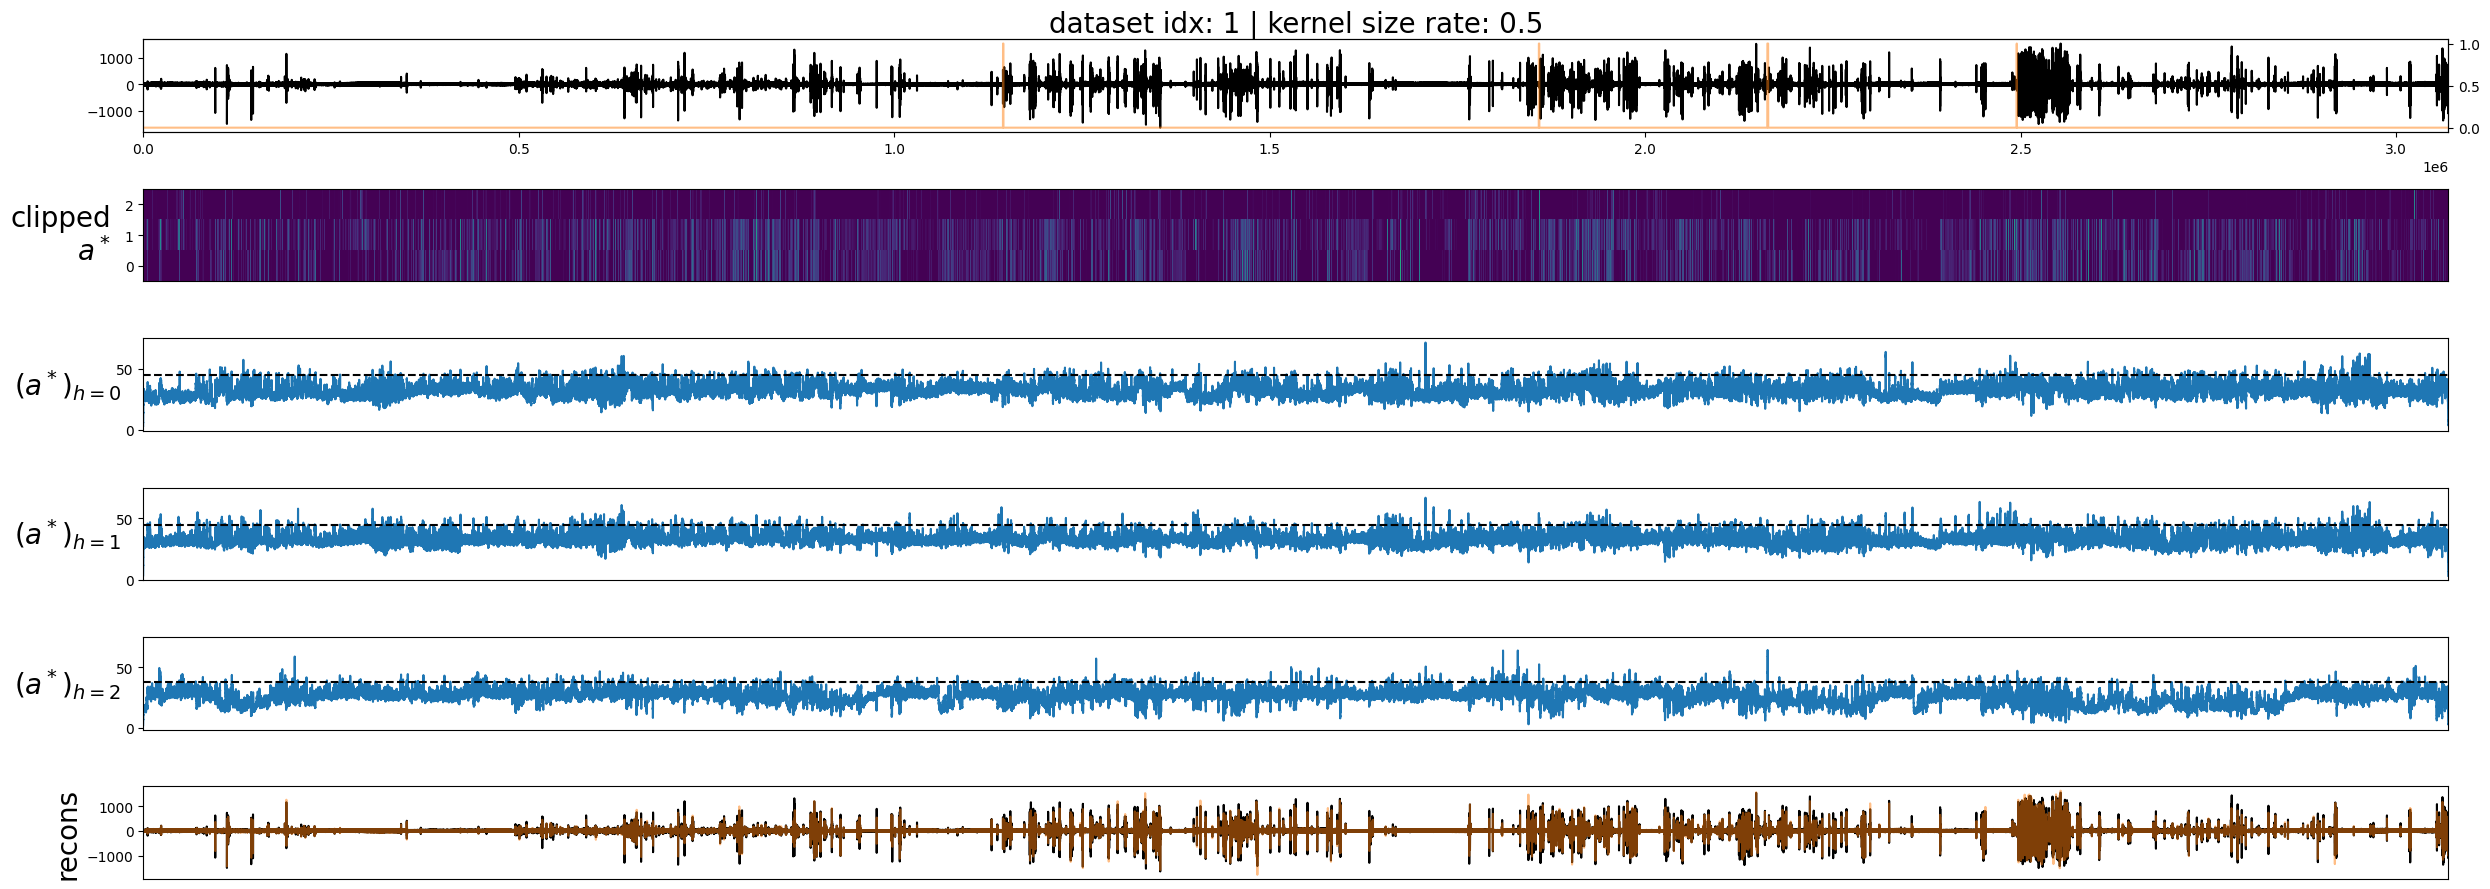

In [ ]:
# take out some vars for plotting
X_test_unscaled = result['X_test_unscaled']
Y = result['Y']
a_star = result['a_star']
anom_threshold = result['anom_threshold']
X_recons_test = result['X_recons_test']
kernel_size_rate = 0.5
# plot
n_rows = 6
fig, axes = plt.subplots(n_rows, 1, figsize=(25, 1.5 * n_rows))

# plot: X_test & labels
i = 0
axes[i].plot(X_test_unscaled, color='black')
axes[i].set_xlim(0, X_test_unscaled.shape[0] - 1)
axes[i].set_title(f"dataset idx: {dataset_index} | kernel size rate: {kernel_size_rate}", fontsize=20)
ax2 = axes[i].twinx()
ax2.plot(Y, alpha=0.5, color='C1')

# plot (imshow): anomaly score
i += 1
vmin = np.nanquantile(np.array(a_star).flatten(), q=0.5)  # q to remove the insignificant values in imshow.
axes[i].imshow(a_star, interpolation='nearest', aspect='auto', vmin=vmin)
axes[i].invert_yaxis()
axes[i].set_xticks([])
ylabel = 'clipped\n' + r'$a^*$'
axes[i].set_ylabel(ylabel, fontsize=20, rotation=0, labelpad=10, ha='right', va='center')

ylim_max = np.max(a_star) * 1.05
for j in range(a_star.shape[0]):
    i += 1
    axes[i].plot(a_star[j])
    axes[i].set_xticks([])
    xlim = (0, a_star[j].shape[0] - 1)
    axes[i].set_xlim(*xlim)
    axes[i].set_ylim(None, ylim_max)
    h_idx = f'h={j}'
    axes[i].set_ylabel(r'$(a^*)_{{{}}}$'.format(h_idx),
                       fontsize=20, rotation=0, labelpad=35, va='center')
    threshold = 1e99 if anom_threshold[j] == np.inf else anom_threshold[j]
    axes[i].hlines(threshold, xmin=xlim[0], xmax=xlim[1], linestyle='--', color='black')

# plot: reconstruction
i += 1
axes[i].plot(X_test_unscaled, color='black')
axes[i].plot(X_recons_test, alpha=0.5, color='C1')
axes[i].set_xticks([])
axes[i].set_xlim(0, X_test_unscaled.shape[0] - 1)
axes[i].set_ylabel('recons', fontsize=20)

plt.tight_layout()
plt.show()

### Load $a^*_s$, $\bar{a}_s^*$, $\bar{\bar{a}}_s^*$, $a_\text{final}$
* $a_\text{final}$: final anomaly scores

In [2]:
# load the pickle resulting data
import pickle
def load_pkl(fname: str):
    with open(fname, 'rb') as f:
        return pickle.load(f)
result = load_pkl("/home/mballo_sw/Repositories/ecg-seizure-detection/TimeVQVAE-AD/evaluation/results/final/no-window/test/098_no_window-joint_anomaly_score.pkl")

In [4]:
result.keys()

dict_keys(['dataset_index', 'X_test_unscaled', 'Y', 'a_s^*', 'bar{a}_s^*', 'doublebar{a}_s^*', 'a_final', 'joint_threshold', 'final_threshold'])

In [5]:
result["Y"]

tensor([0, 0, 0,  ..., 0, 0, 0])

In [7]:
final_threshold = result["final_threshold"]
final_threshold

457.2969334920247

In [ ]:
a_final = result["a_final"]


array([94.94439419, 95.08198245, 95.21885782, ..., 98.37324215,
       98.21760863, 98.06116663])

In [11]:
(a_final>final_threshold*0.8).sum()

2414

**Details of the stored data keys**
* a_s^*: $a_s^*$
* bar{a}_s^*: $\bar{a}_s^*$
* doublebar{a}_s^*: $\bar{\bar{a}}_s^*$
* a_final: $a_\text{final}$
* joint_threshold: a summation of `anom_threshold` across different latent_window_size_rate-s
* final_threshold: an average of `joint_threshold` across different frequency bands.

IndexError: index 9 is out of bounds for axis 0 with size 9

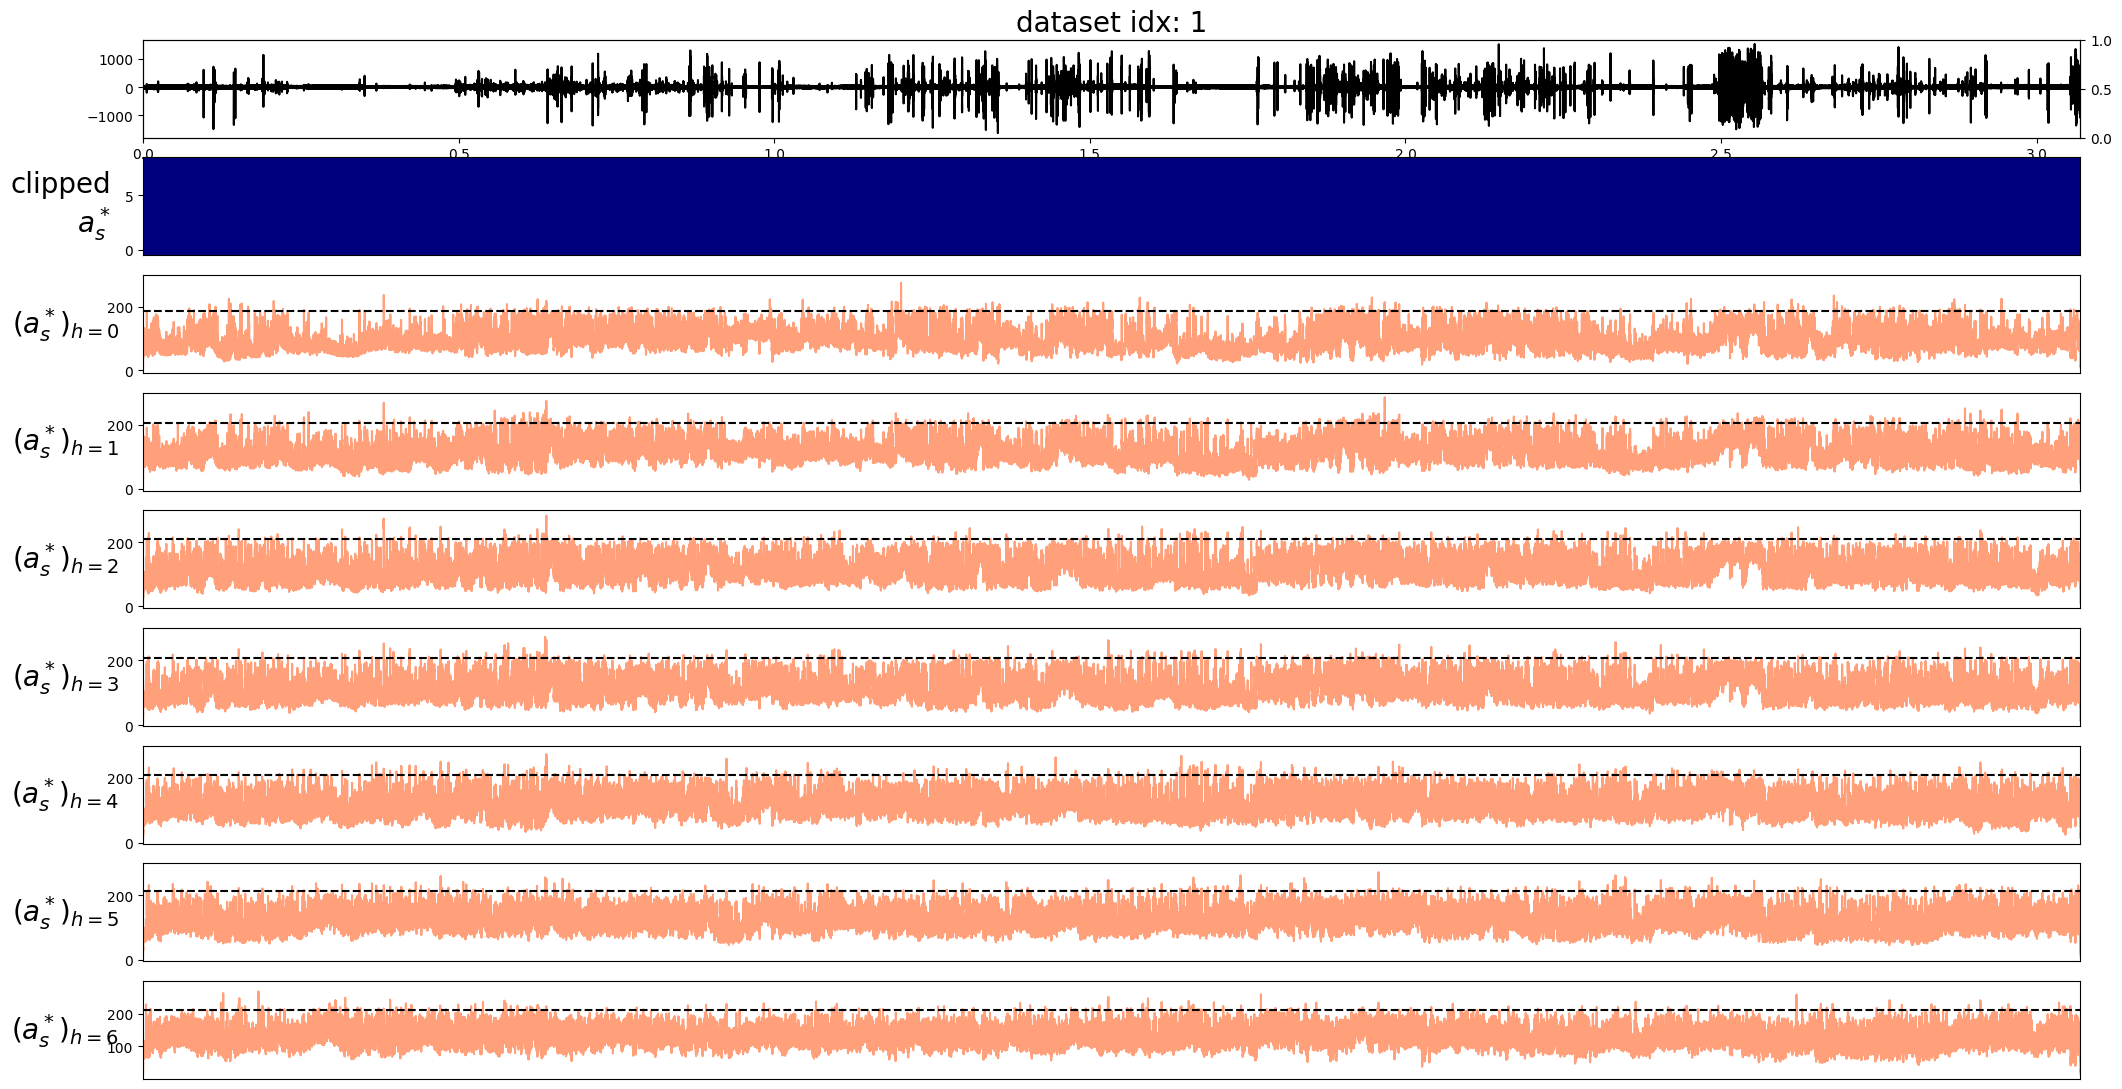

In [ ]:
# take out some vars for plotting
a_s_star = result['a_s^*']
a_bar_s_star = result['bar{a}_s^*']
a_2bar_s_star = result['doublebar{a}_s^*']
a_final = result['a_final']
joint_threshold = result['joint_threshold']
final_threshold = result['final_threshold']
X_test_unscaled = result['X_test_unscaled']
# plot
n_rows = 9
fig, axes = plt.subplots(n_rows, 1, figsize=(25, 1.5 * n_rows))

# plot: X_test & labels
i = 0
axes[i].plot(X_test_unscaled, color='black')
axes[i].set_xlim(0, X_test_unscaled.shape[0] - 1)
axes[i].set_title(f"dataset idx: {dataset_index}", fontsize=20)
ax2 = axes[i].twinx()
#ax2.plot(Y, alpha=0.5, color='C1')

# plot (imshow): a_s^*
i += 1
anom_ind = a_final > final_threshold
a_s_star_clipped = np.copy(a_s_star)
a_s_star_clipped[:, ~anom_ind] = 0. if anom_ind.mean() == 0 else np.min(a_s_star_clipped[:, anom_ind])
axes[i].imshow(a_s_star_clipped, interpolation='nearest', aspect='auto', cmap='jet')  # , vmin=vmin)
axes[i].invert_yaxis()
axes[i].set_xticks([])
ylabel = 'clipped\n' + r'$a_s^*$'
axes[i].set_ylabel(ylabel, fontsize=20, rotation=0, labelpad=10, ha='right', va='center')

# plot: a_s^*
n_freq = a_s_star.shape[0]
max_anom = a_s_star.max()
for j in range(n_freq):
    i += 1
    axes[i].plot(a_s_star[j], color='lightsalmon')
    axes[i].set_xticks([])
    axes[i].set_xlim(0, a_s_star.shape[1] - 1)
    h_idx = f'h={j}'
    axes[i].set_ylabel(r'$(a_s^*)_{{{}}}$'.format(h_idx), fontsize=20, rotation=0, labelpad=30, va='center')
    axes[i].set_ylim(None, max_anom + 0.05 * max_anom)
    axes[i].hlines(joint_threshold[j], xmin=0, xmax=len(a_s_star[j]) - 1, linestyle='--', color='black')

# plot: bar{a}_s^*
i += 1
axes[i].plot(a_bar_s_star, color='darkturquoise')
axes[i].set_xticks([])
axes[i].set_xlim(0, len(a_bar_s_star) - 1)
axes[i].set_ylabel(r'$\bar{a}_s^*$', fontsize=20, rotation=0, labelpad=15, va='center')
axes[i].hlines(final_threshold, xmin=0, xmax=len(a_bar_s_star) - 1, linestyle='--', color='black')

# plot: doublebar{a}_s^*
i += 1
rng = np.arange(len(a_2bar_s_star))
axes[i].plot(rng, a_2bar_s_star, color='royalblue')
axes[i].set_xticks([])
axes[i].set_xlim(0, len(a_2bar_s_star) - 1)
axes[i].set_ylabel(r'$\bar{\bar{a}}_s^*$', fontsize=20, rotation=0, labelpad=15, va='center')
axes[i].hlines(final_threshold, xmin=0, xmax=len(a_2bar_s_star) - 1, linestyle='--', color='black')

# plot: a_final
i += 1
rng = np.arange(len(a_final))
axes[i].plot(rng, a_final, color='red')
axes[i].set_xticks([])
axes[i].set_xlim(0, len(a_final) - 1)
axes[i].set_ylabel(r'$a_{final}$', fontsize=20, rotation=0, labelpad=25, va='center')
axes[i].hlines(final_threshold, xmin=0, xmax=len(a_final) - 1, linestyle='--', color='black')

plt.tight_layout()
plt.show()

# Custom evaluation

In [ ]:
min_threshhold = min(joint_threshold)
min_threshhold

179.41135188341133

In [ ]:
np.max(a_final), final_threshold

(201.85614550305925, 203.51224810971152)

In [ ]:
pred_bool = a_s_star[1] > final_threshold

In [ ]:
sum(pred_bool)

15849

In [ ]:
Y = result['Y']

In [ ]:
pred_Y = pred_bool.astype(int)
truth = Y.bool()

In [ ]:
pred =  pred_Y#smooth_labels(pred_Y, 20*8, 6*8)

[(1144880, 1145455),
 (1858328, 1858975),
 (2162608, 2163751),
 (2494632, 2494831)]

In [ ]:
# pred and truth are 1D boolean numpy arrays
# fs = your ECG sampling rate (e.g. 8.0 Hz)
metrics = evaluate_event_detection(pred, truth, fs=8.0)

print("True events:", metrics['truth_events'])
print("Predicted events:", metrics['pred_events'])
print(f"TP={metrics['TP_events']}, FN={metrics['FN_events']}, FP={metrics['FP_events']}")
print(f"Sensitivity: {metrics['sensitivity']:.3f}, Event-IoU: {metrics['event_iou']:.3f}")
if 'false_alarm_rate_per_hour' in metrics:
    print(f"False alarms per hour: {metrics['false_alarm_rate_per_hour']:.2f}")

True events: [(1142480, 1146895), (1855928, 1860415), (2160208, 2165191), (2492232, 2496271)]
Predicted events: [(105347, 105385), (114831, 114881), (114884, 114958), (136046, 136056), (138677, 138751), (154218, 154228), (154231, 154255), (156129, 156153), (156438, 156461), (156464, 156475), (156488, 156538), (156541, 156604), (208747, 208821), (215868, 215894), (215908, 215918), (254972, 255035), (262363, 262427), (342738, 342750), (342777, 342801), (381418, 381532), (396845, 396855), (397743, 397755), (408921, 408944), (408947, 408971), (422549, 422573), (422576, 422650), (429531, 429555), (446663, 446674), (446677, 446688), (457237, 457288), (457290, 457300), (500922, 500948), (527230, 527242), (528617, 528655), (557197, 557247), (557249, 557272), (567438, 567487), (570659, 570696), (570698, 570721), (570724, 570786), (571250, 571260), (571263, 571273), (571352, 571390), (572596, 572646), (572648, 572672), (574843, 574854), (574970, 574982), (576601, 576612), (576640, 576650), (5766

In [ ]:
(len(pred))

NameError: name 'pred' is not defined

In [ ]:
# Example: Optimized parameters for detecting small anomalies in large time series

def evaluate_with_optimized_parameters():
    """
    Example of how to modify evaluation parameters for better small anomaly detection
    """
    
    # Load the joint anomaly score data
    result = load_pkl(os.path.join('results', f'{dataset_index:03d}-joint_anomaly_score.pkl'))
    
    a_s_star = result['a_s^*']
    a_final = result['a_final'] 
    joint_threshold = result['joint_threshold']
    final_threshold = result['final_threshold']
    Y = result['Y']
    truth = Y.astype(bool)
    
    print("=== OPTIMIZED PARAMETERS FOR SMALL ANOMALY DETECTION ===\n")
    
    # Strategy 1: Lower quantile threshold (more sensitive)
    print("1. Lower Threshold Strategy:")
    lower_threshold = final_threshold * 0.7  # 30% lower threshold
    pred_lower = a_final > lower_threshold
    metrics_lower = evaluate_event_detection(pred_lower, truth, fs=8.0)
    
    print(f"   Lower threshold (70% of original): {lower_threshold:.4f}")
    print(f"   Predicted anomaly percentage: {(pred_lower.sum() / len(pred_lower)) * 100:.2f}%")
    print(f"   Recall: {metrics_lower['sensitivity']:.3f}")
    print(f"   False alarms per hour: {metrics_lower['false_alarm_rate_per_hour']:.2f}\n")
    
    # Strategy 2: Use best performing frequency band with lower threshold
    print("2. Best Frequency Band with Lower Threshold:")
    best_freq_idx = np.argmin(joint_threshold)  # Band with lowest threshold
    freq_threshold = joint_threshold[best_freq_idx] * 0.8  # 20% lower
    pred_freq_lower = a_s_star[best_freq_idx] > freq_threshold
    metrics_freq_lower = evaluate_event_detection(pred_freq_lower, truth, fs=8.0)
    
    print(f"   Best frequency band: h={best_freq_idx}")
    print(f"   Lower threshold: {freq_threshold:.4f}")
    print(f"   Predicted anomaly percentage: {(pred_freq_lower.sum() / len(pred_freq_lower)) * 100:.2f}%")
    print(f"   Recall: {metrics_freq_lower['sensitivity']:.3f}")
    print(f"   False alarms per hour: {metrics_freq_lower['false_alarm_rate_per_hour']:.2f}\n")
    
    # Strategy 3: Adaptive threshold based on local statistics
    print("3. Adaptive Threshold Strategy:")
    # Use rolling percentile for adaptive thresholding
    window_size = 1000  # Adjust based on your data characteristics
    rolling_percentile = np.zeros_like(a_final)
    
    for i in range(len(a_final)):
        start_idx = max(0, i - window_size // 2)
        end_idx = min(len(a_final), i + window_size // 2)
        rolling_percentile[i] = np.percentile(a_final[start_idx:end_idx], 85)  # 85th percentile
    
    pred_adaptive = a_final > rolling_percentile
    metrics_adaptive = evaluate_event_detection(pred_adaptive, truth, fs=8.0)
    
    print(f"   Adaptive threshold (85th percentile in rolling window)")
    print(f"   Predicted anomaly percentage: {(pred_adaptive.sum() / len(pred_adaptive)) * 100:.2f}%")
    print(f"   Recall: {metrics_adaptive['sensitivity']:.3f}")
    print(f"   False alarms per hour: {metrics_adaptive['false_alarm_rate_per_hour']:.2f}\n")
    
    # Strategy 4: Minimal smoothing for preserving small anomalies
    print("4. Minimal Smoothing Strategy:")
    pred_baseline = a_final > final_threshold
    # Very light smoothing to preserve small anomalies
    pred_light_smooth = smooth_labels(pred_baseline.astype(int), 
                                    window_size_samples=16,  # 2 seconds at 8Hz
                                    threshold_count=8)       # 1 second of anomalies
    metrics_light_smooth = evaluate_event_detection(pred_light_smooth, truth, fs=8.0)
    
    print(f"   Light smoothing (2s window, 1s threshold)")
    print(f"   Predicted anomaly percentage: {(pred_light_smooth.sum() / len(pred_light_smooth)) * 100:.2f}%")
    print(f"   Recall: {metrics_light_smooth['sensitivity']:.3f}")
    print(f"   False alarms per hour: {metrics_light_smooth['false_alarm_rate_per_hour']:.2f}\n")
    
    # Summary table
    strategies = {
        'Original': evaluate_event_detection(a_final > final_threshold, truth, fs=8.0),
        'Lower Threshold': metrics_lower,
        'Best Freq Lower': metrics_freq_lower, 
        'Adaptive': metrics_adaptive,
        'Light Smooth': metrics_light_smooth
    }
    
    print("=== COMPARISON SUMMARY ===")
    print(f"{'Strategy':<15} {'Recall':<8} {'FAR/hr':<8} {'Event-IoU':<10}")
    print("-" * 50)
    
    for name, metrics in strategies.items():
        print(f"{name:<15} {metrics['sensitivity']:<8.3f} {metrics['false_alarm_rate_per_hour']:<8.2f} {metrics['event_iou']:<10.3f}")
    
    return strategies

# Run the optimized evaluation
optimized_results = evaluate_with_optimized_parameters()

## How to Modify Parameters in Your Evaluation Script

To implement these optimizations in your main evaluation (`evaluate.py`), modify these parameters:

### 1. **In `evaluate.py`** - Change default arguments:
```python
parser.add_argument('--latent_window_size_rates', default=[0.05, 0.1, 0.2], nargs='+')  # Smaller values
parser.add_argument('--rolling_window_stride_rate', default=0.05, type=float)          # Smaller stride  
parser.add_argument('--q', default=0.95, type=float)                                   # Lower quantile
```

### 2. **In `config.yaml`** - Adjust window parameters:
```yaml
dataset:
  n_periods: 3          # Shorter windows for higher resolution (vs. 5)
  downsample_freq: 16   # Higher sampling rate if computationally feasible (vs. 8)
```

### 3. **Re-run evaluation** with optimized parameters:
```bash
python evaluate.py --latent_window_size_rates 0.05 0.1 0.2 --rolling_window_stride_rate 0.05 --q 0.95
```

### 4. **Post-processing** - Use lighter smoothing in analysis:
```python
# Instead of heavy smoothing (60s window, 50s threshold)
pred_smooth = smooth_labels(pred, window_size_samples=16, threshold_count=8)  # 2s window, 1s threshold
```

In [ ]:
# Visualization function to compare different strategies
def plot_parameter_comparison():
    """
    Visualize the effect of different parameter strategies on anomaly detection
    """
    result = load_pkl(os.path.join('results', f'{dataset_index:03d}-joint_anomaly_score.pkl'))
    a_final = result['a_final']
    final_threshold = result['final_threshold']
    Y = result['Y']
    X_test_unscaled = result['X_test_unscaled']
    
    # Create different predictions
    pred_original = a_final > final_threshold
    pred_lower = a_final > (final_threshold * 0.7)
    pred_adaptive = a_final > np.percentile(a_final, 85)  # Simplified adaptive
    
    # Plot comparison
    fig, axes = plt.subplots(5, 1, figsize=(20, 15))
    
    # Original signal with ground truth
    axes[0].plot(X_test_unscaled, color='black', alpha=0.7, label='ECG Signal')
    ax0_twin = axes[0].twinx()
    ax0_twin.fill_between(range(len(Y)), 0, Y, alpha=0.4, color='red', label='True Anomalies')
    axes[0].set_title('ECG Signal with Ground Truth Anomalies', fontsize=14)
    axes[0].legend(loc='upper left')
    ax0_twin.legend(loc='upper right')
    
    # Final anomaly score with different thresholds
    axes[1].plot(a_final, color='blue', label='Final Anomaly Score', alpha=0.8)
    axes[1].axhline(y=final_threshold, color='red', linestyle='--', alpha=0.7, label='Original Threshold')
    axes[1].axhline(y=final_threshold*0.7, color='orange', linestyle='--', alpha=0.7, label='Lower Threshold (70%)')
    axes[1].axhline(y=np.percentile(a_final, 85), color='green', linestyle='--', alpha=0.7, label='Adaptive Threshold (85%)')
    axes[1].set_title('Anomaly Scores with Different Thresholds', fontsize=14)
    axes[1].legend()
    axes[1].set_ylabel('Anomaly Score')
    
    # Original predictions
    axes[2].fill_between(range(len(Y)), 0, Y, alpha=0.4, color='red', label='Ground Truth')
    axes[2].fill_between(range(len(pred_original)), 0, pred_original.astype(int), alpha=0.6, color='blue', label='Original Predictions')
    axes[2].set_title('Original Strategy Predictions vs Ground Truth', fontsize=14)
    axes[2].legend()
    axes[2].set_ylabel('Anomaly Flag')
    
    # Lower threshold predictions
    axes[3].fill_between(range(len(Y)), 0, Y, alpha=0.4, color='red', label='Ground Truth')
    axes[3].fill_between(range(len(pred_lower)), 0, pred_lower.astype(int), alpha=0.6, color='orange', label='Lower Threshold Predictions')
    axes[3].set_title('Lower Threshold Strategy (70% of original)', fontsize=14)
    axes[3].legend()
    axes[3].set_ylabel('Anomaly Flag')
    
    # Adaptive threshold predictions
    axes[4].fill_between(range(len(Y)), 0, Y, alpha=0.4, color='red', label='Ground Truth')
    axes[4].fill_between(range(len(pred_adaptive)), 0, pred_adaptive.astype(int), alpha=0.6, color='green', label='Adaptive Predictions')
    axes[4].set_title('Adaptive Threshold Strategy', fontsize=14)
    axes[4].legend()
    axes[4].set_ylabel('Anomaly Flag')
    axes[4].set_xlabel('Sample Index')
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics comparison
    truth = Y.astype(bool)
    strategies = {
        'Original': evaluate_event_detection(pred_original, truth, fs=8.0),
        'Lower (70%)': evaluate_event_detection(pred_lower, truth, fs=8.0),
        'Adaptive': evaluate_event_detection(pred_adaptive, truth, fs=8.0)
    }
    
    print("\n=== VISUAL COMPARISON METRICS ===")
    print(f"{'Strategy':<12} {'Recall':<8} {'FAR/hr':<8} {'Pred %':<8}")
    print("-" * 40)
    
    for name, metrics in strategies.items():
        pred_pct = {
            'Original': (pred_original.sum() / len(pred_original)) * 100,
            'Lower (70%)': (pred_lower.sum() / len(pred_lower)) * 100,
            'Adaptive': (pred_adaptive.sum() / len(pred_adaptive)) * 100
        }[name]
        
        print(f"{name:<12} {metrics['sensitivity']:<8.3f} {metrics['false_alarm_rate_per_hour']:<8.2f} {pred_pct:<8.2f}")
    
    return strategies

# Run the visualization
print("Generating parameter comparison plots...")
comparison_results = plot_parameter_comparison()

# Optimizing for Small Anomalies in Large Time Series

For very large time series with very small anomalies, you can optimize several parameters:

## 1. **Latent Window Size Rate** (`latent_window_size_rate`)
- **Current values**: `[0.1, 0.3, 0.5]`
- **For small anomalies**: Use **smaller values** like `[0.05, 0.1, 0.2]`
- **Reasoning**: Smaller latent windows provide higher resolution in anomaly detection

## 2. **Rolling Window Stride Rate** (`rolling_window_stride_rate`)
- **Current value**: `0.1` (10% of window size)
- **For small anomalies**: Use **smaller values** like `0.05` or `0.02` (5% or 2%)
- **Reasoning**: Smaller strides = more overlapping windows = better coverage of small anomalies

## 3. **Quantile Threshold** (`q`)
- **Current value**: `0.99` (99th percentile)
- **For small anomalies**: Use **lower values** like `0.95` or `0.90`
- **Reasoning**: Lower thresholds are more sensitive to detect subtle anomalies

## 4. **Window Size** (controlled by `n_periods`)
- **For small anomalies**: Consider using **shorter windows** to capture local patterns
- **Trade-off**: Shorter windows = higher resolution but less context

## 5. **Smoothing Parameters**
- **Current**: `window_size_samples = 60*8, threshold_count = 50*8`
- **For small anomalies**: Use **smaller smoothing** to preserve sharp anomaly peaks